# Tomograf


In [2]:
from ipywidgets import *
from PIL import Image
import numpy as np
from skimage.draw import line
from IPython.display import display
import pydicom
from datetime import date
import matplotlib.pyplot as plt

### Tworzymy klasę odpowiadającą za przetwarzanie obrazu wejściowego na sinogram oraz późniejszą rekonstrukcję tego obrazu

In [104]:
class Tomograph:
    def configure(self, img, *, alpha=1, n_detectors=1000, phi=np.pi, hamm_filter=True):
        self.img = img
        self.__reshape_img()
        self.img = np.asarray(self.img)
        self.alpha = alpha
        self.n_detectors = n_detectors
        self.phi = phi
        self.n_steps = int(np.floor(180 / self.alpha))
        self.generated_sinogram = np.zeros((self.n_steps, self.n_detectors), dtype=int)
        self.bresenham_lines = []
        self.hamm_filter = hamm_filter
        self.reconstructed = []

    def __reshape_img(self):
        width, height = self.img.size
        new_size = max(width, height)
        self.img = self.img.resize((new_size, new_size))

    def __map_coords(self, angle):
        width = int(self.img.shape[0] / 2)
        x = int(np.cos(angle) * width) + width - 1
        y = -int(np.sin(angle) * width) + width - 1
        return x, y

    def get_sinogram(self):
        return Image.fromarray(self.generated_sinogram).convert('L')

    def __normalize_img(self, img):
        brightest_pixel = np.max(img)
        if brightest_pixel == 0:
            return img
        return img / brightest_pixel * 255

    def generate_sinogram(self):
        i = 0
        sl_filter = self.__hamming_filter(self.n_detectors)
        for angle in np.arange(0, np.pi, self.alpha * (np.pi / 180)):
            for detector in range(self.n_detectors):
                emitter_angle = angle + self.phi / 2 - detector * self.phi / (self.n_detectors - 1)
                emitter_coordX, emitter_coordY = self.__map_coords(emitter_angle)
                detector_angle = angle + np.pi - self.phi / 2 + detector * self.phi / (self.n_detectors - 1)
                detector_coordX, detector_coordY = self.__map_coords(detector_angle)

                rr, cc = line(emitter_coordX, emitter_coordY, detector_coordX, detector_coordY)
                self.generated_sinogram[i][detector] += self.img[rr, cc].sum()
                self.bresenham_lines.append([rr, cc])

            if self.hamm_filter:
                self.generated_sinogram[i] = np.array(np.convolve(self.generated_sinogram[i], sl_filter, 'same'))
            i += 1

        self.generated_sinogram = self.__normalize_img(self.generated_sinogram)

    def reconstruct(self):
        reconstructed_img = np.zeros((self.img.shape[0], self.img.shape[1]))
        i = 0
        generated_sinogram_flattened = self.generated_sinogram.flatten()
        for bresenham_line in self.bresenham_lines:
            rr, cc = bresenham_line
            reconstructed_img[rr, cc] += generated_sinogram_flattened[i]
            i += 1
            if i % 100 == 0:
                self.reconstructed.append(reconstructed_img.copy())
                self.reconstructed[-1] = self.__normalize_img(self.reconstructed[-1])
                self.reconstructed[-1] = Image.fromarray(self.reconstructed[-1]).convert('L')
                # print(i)
        else:
            self.reconstructed.append(reconstructed_img.copy())
            self.reconstructed[-1] = self.__normalize_img(self.reconstructed[-1])
            self.reconstructed[-1] = Image.fromarray(self.reconstructed[-1]).convert('L')
                # print(i)
    
    def get_reconstructed(self, number):
        return self.reconstructed[number].resize((400, 400))
    
    def get_all_reconstructed(self):
        return self.reconstructed
    
    def get_final_reconstructed(self):
        return self.reconstructed[-1]

    def get_images_number(self):
        return len(self.reconstructed)

    # Ram-Lak with hamming filter
    def __hamming_filter(self, length):
        filter = []
        ham = np.hamming(length)
        length = int(length/2)
        for i, j in zip(range(-length, length), ham):
            if i % 2 != 0:
                val = ((-4/np.pi**2)/(i**2)) * j
                filter.append(val)
            else:
                filter.append(0)
        filter[int(length)] = 1

        return filter
    
    def run(self, source, *, alpha=1, n_detectors=1000, phi=np.pi, hamm_filter=True):
        initial_img = Image.open(source).convert('L')
        self.configure(initial_img, alpha=alpha, n_detectors=n_detectors, phi=phi, hamm_filter=hamm_filter)
        self.generate_sinogram()
        path = 'Output/Sinogram/sinogram.jpg'
        self.get_sinogram().save(path)
        display(Image.open(path))
        self.reconstruct()
        
    def get_initial_img(self):
        return self.img
    
def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))


### Wprowadzanie parametrów urządzenia:
-  SOURCE_IMAGE_PATH - lokalizacja obrazu wejściowego
-  ALPHA - Krok układu emiter/detektor w stopniach
-  N_DETECTORS - liczba detektorów użytych dla jednego kąta nachylenia układu emiter/detektor
-  PHI - rozpiętość układu emiter/detektor w radianach
- SHOW_MIDDLE_STEPS - pokazuje stany pośrednie rekonstrukcji obrazu

Na wyjściu otrzymujemy kolejno:
1. obraz wejściowy
2. sinogram
3. zrekonstruowany obraz

In [ ]:
# config
SOURCE_IMAGE_PATH = 'Input\Img\Kwadraty2.jpg'
ALPHA = 1
N_DETECTORS = 100
PHI = np.pi
SHOW_MIDDLE_STEPS = True
# config

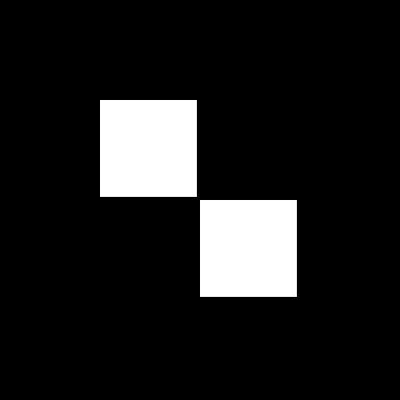

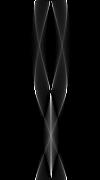

interactive(children=(IntSlider(value=0, description='number', max=180), Output()), _dom_classes=('widget-inte…

In [105]:
display(Image.open(SOURCE_IMAGE_PATH).resize((400, 400)))
tomograph = Tomograph()
tomograph.run(source=SOURCE_IMAGE_PATH, hamm_filter=True, alpha=ALPHA, n_detectors=N_DETECTORS, phi=PHI)
if SHOW_MIDDLE_STEPS:
    interact(tomograph.get_reconstructed, number=IntSlider(value=0, min=0, max=tomograph.get_images_number()-1))
else:
    display(tomograph.get_reconstructed(-1))


### Tworzymy klasę odpowiedzialną za zapisanie pliku w formacie DICOM

In [106]:
class Dicom:
    def load_image(dicom_file):
        img = dicom_file.pixel_array.astype(float)
        rescaled_img = (np.maximum(img, 0) / img.max()) * 255
        final_img = np.uint8(rescaled_img)
        final_img = Image.fromarray(final_img)
        return final_img

    def load_file(path):
        ds = pydicom.dcmread(path)
        patientData = {}
        patientData['PatientName'] = ds['PatientName'].value
        patientData['StudyDate'] = ds['StudyDate'].value
        patientData['StudyDescription'] = ds['StudyDescription'].value
        patientData['Image'] = Dicom.load_image(ds)
        return patientData

    def save_file(patientData, path):
        img = np.asarray(patientData['Image'])
        ds = pydicom.dcmread('Input/Dicom/dicom.dcm')

        ds.PatientName = patientData['PatientName']
        ds.StudyDate = Dicom.convert_date(patientData['StudyDate'])
        ds.StudyDescription = patientData['StudyDescription']
        ds.PixelData = patientData['Image'].tobytes()

        ds.Rows = img.shape[0]
        ds.Columns = img.shape[1]
        ds.SamplesPerPixel = 1
        ds.BitsStored = 8
        ds.BitsAllocated = 8
        ds.HighBit = 7
        ds.PixelRepresentation = 0

        ds.save_as(path)

    def convert_date(date):
        return date.strftime('%Y%m%d')

### Podajemy parametry pliku do zapisania w formacie DICOM

In [107]:
#config
NAME = 'Stefan Zbaszyniak'
YEAR = 2023
MONTH = 3
DAY = 10
DESCRIPTION = 'Test'
IMAGE_PATH = 'Output\Sinogram\sinogram.jpg'
#config


studyDate = date(year=YEAR, month=MONTH, day=DAY)
img = Image.open(IMAGE_PATH).convert('L')
patientData = {'PatientName': NAME, 'StudyDescription': DESCRIPTION, 'Image': img,
                   'StudyDate': studyDate}
Dicom.save_file(patientData, 'Output/Dicom/dicom.dcm')

### Odczytujemy dane z zapisanego wcześniej pliku

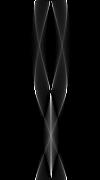

'Stefan Zbaszyniak'

'20230310'

'Test'

In [108]:
path = 'Output/Dicom/dicom.dcm'
patientData = Dicom.load_file(path)
display(patientData['Image'])
display(patientData['PatientName'])
display(patientData['StudyDate'])
display(patientData['StudyDescription'])

### Wyliczamy statystyki dokładności działania tomografu

In [109]:
initial_img = Image.fromarray(tomograph.get_initial_img())
mse = []
for img in tomograph.get_all_reconstructed():
    diff = rmse(np.asarray(img), tomograph.get_initial_img())
    mse.append(diff)

plt.plot(range(tomograph.get_images_number()), mse)
plt.title('Zależność RMSE dla pośrednich obrazów rekonstrukcji')
plt.xlabel('Numer obrazu')
plt.ylabel('Błąd średniokwadratowy')
plt.xlim((0, tomograph.get_images_number()-1))
# plt.show()
plt.savefig('Experiment_Results/fig0')
plt.clf()

range_n_detectors = [i for i in range(90, 721, 90)]
range_n_steps = [i for i in range(90, 721, 90)]
range_alpha = [180/i for i in range(90, 721, 90)]
range_degrees = [i for i in range(45, 271, 45)]
range_phi = [np.pi/180 * i for i in range_degrees]

# Zależność rekonstrukcji obrazu od liczby detektorów
mse = []
for step in range_n_detectors:
    t = Tomograph()
    t.configure(initial_img, n_detectors=step, alpha=2, phi=np.pi)
    t.generate_sinogram()
    t.reconstruct()
    img = t.get_final_reconstructed()
    diff = rmse(np.asarray(img), np.asarray(t.get_initial_img()))
    mse.append(diff)

plt.plot(range_n_detectors, mse)
plt.title('Zależność RMSE od liczby detektorów')
plt.xlabel('Liczba detektorów')
plt.ylabel('Błąd średniokwadratowy')
plt.xlim((range_n_detectors[0], range_n_detectors[-1]))
plt.savefig('Experiment_Results/fig1')
#plt.show()
plt.clf()

# Zależność rekonstrukcji obrazu od liczby kroków
mse = []
for step in range_alpha:
    t = Tomograph()
    t.configure(initial_img, n_detectors=180, alpha=step, phi=np.pi)
    t.generate_sinogram()
    t.reconstruct()
    img = t.get_final_reconstructed()
    diff = rmse(np.asarray(img), np.asarray(t.get_initial_img()))
    mse.append(diff)

plt.plot(range_n_steps, mse)
plt.title('Zależność RMSE od liczby kroków')
plt.xlabel('Liczba kroków')
plt.ylabel('Błąd średniokwadratowy')
plt.xlim((range_n_steps[0], range_n_steps[-1]))
plt.savefig('Experiment_Results/fig2')
#plt.show()
plt.clf()

# Zależność rekonstrukcji obrazu od rozpiętości wachlarza
mse = []
for step in range_phi:
    t = Tomograph()
    t.configure(initial_img, n_detectors=180, alpha=2, phi=step)
    t.generate_sinogram()
    t.reconstruct()
    img = t.get_final_reconstructed()
    diff = rmse(np.asarray(img), np.asarray(t.get_initial_img()))
    mse.append(diff)

plt.plot(range_degrees, mse)
plt.title('Zależność RMSE od rozpiętości wachlarza')
plt.xlabel('Rozpiętość wachlarza (°)')
plt.ylabel('Błąd średniokwadratowy')
plt.xlim((range_degrees[0], range_degrees[-1]))
plt.savefig('Experiment_Results/fig3')
#plt.show()
plt.clf()

path = 'Input/Img/Shepp_logan.jpg'
initial_img = Image.open(path).convert('L')
t = Tomograph()
t.configure(initial_img, n_detectors=180, alpha=2, phi=270 * np.pi/180, hamm_filter=True)
t.generate_sinogram()
for img in t.reconstruct(n_images=1):
    diff = t.rmse(np.asarray(img), np.asarray(t.get_initial_img()))
    print('Błąd średniokwadratowy dla', path, 'z użyciem filtra:', diff)
    img.save('Experiment_Results/Shepp_logan_filtered.png')

t = Tomograph()
t.configure(initial_img, n_detectors=180, alpha=2, phi=270 * np.pi/180, hamm_filter=False)
t.generate_sinogram()
for img in t.reconstruct(n_images=1):
    diff = t.rmse(np.asarray(img), np.asarray(t.get_initial_img()))
    print('Błąd średniokwadratowy dla', path, 'bez filtra:', diff)
    img.save('Experiment_Results/Shepp_logan_unfiltered.png')

<Figure size 640x480 with 0 Axes>

### Wizualizacja otrzymanych danych

In [3]:
display(widgets.HBox([widgets.Image(value=open('Experiment_Results/fig0.png', 'rb').read(), format='png'),
                      widgets.Image(value=open('Experiment_Results/fig1.png', 'rb').read(), format='png')]))
display(widgets.HBox([widgets.Image(value=open('Experiment_Results/fig2.png', 'rb').read(), format='png'),
                      widgets.Image(value=open('Experiment_Results/fig3.png', 'rb').read(), format='png')]))